In [ ]:
# Notebook adapted from https://github.com/magenta/magenta-demos/blob/main/jupyter-notebooks/Sketch_RNN.ipynb
# Most part of cells were maintained from original document 

In [ ]:
# import the required libraries
import numpy as np
import time
import random
import pickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
import logging
import sys
from six.moves import xrange

In [ ]:
# install correct numba version and import
!pip install -q numba==0.48

import numba
from numba import jit as optional_jit

     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 20.2 MB 46.6 MB/s 


In [ ]:
# disable tf eager_execution
tf.compat.v1.disable_eager_execution()

In [ ]:
# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [ ]:
!pip install -qU svgwrite

import svgwrite # conda install -c omnia svgwrite=1.1.6

     |████████████████████████████████| 66 kB 2.5 MB/s 


In [ ]:
# mount 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# install magenta libraries from my drive because i changed some parameters due to old dependencies.
# can be found at https://github.com/rogerbbatista/sketch-rnn/tree/main/modules/magenta-2.1.3
# when this work was developed the dependencies were not yet solved, but if you want the original module, remove the comment from code bellow
# !pip install -q magenta
!pip install -q '/content/drive/MyDrive/TCC/modules/magenta-2.1.3'

ERROR: Invalid requirement: '/content/drive/MyDrive/TCC/modules/magenta-2.1.3'
Hint: It looks like a path. File '/content/drive/MyDrive/TCC/modules/magenta-2.1.3' does not exist.


In [ ]:
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

Utility methods for visualization


In [ ]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

In [ ]:
data_dir = '/content/drive/MyDrive/TCC/datasets' # Datasets folder 
models_root_dir = '/content/drive/MyDrive/TCC/models' # Models path
model_dir = models_root_dir + '/interpolation_lr00001' # Current model path

In [ ]:
def load_env_compatible(data_dir, model_dir):
  """Loads environment for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))
  return load_dataset(data_dir, model_params, inference_mode=True)

def load_model_compatible(model_dir):
  """Loads model for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))

  model_params.batch_size = 1  # only sample one at a time
  eval_model_params = sketch_rnn_model.copy_hparams(model_params)
  eval_model_params.use_input_dropout = 0
  eval_model_params.use_recurrent_dropout = 0
  eval_model_params.use_output_dropout = 0
  eval_model_params.is_training = 0
  sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
  sample_model_params.max_seq_len = 1  # sample one point at a time
  return [model_params, eval_model_params, sample_model_params]

In [ ]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env_compatible(data_dir, model_dir)

INFO:tensorflow:Loaded 249734/2500/2500 from yoga.npz
INFO:tensorflow:Loaded 105431/2500/2500 from palmtree.npz
INFO:tensorflow:Loaded 107708/2500/2500 from flamingo.npz
INFO:tensorflow:Dataset combined: 477873 (462873/7500/7500), avg len 53
INFO:tensorflow:model_params.max_seq_len 121.
total images <= max_seq_len is 462873
total images <= max_seq_len is 7500
total images <= max_seq_len is 7500
INFO:tensorflow:normalizing_scale_factor 48.9010.


In [ ]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /content/drive/MyDrive/TCC/models/interpolation_lr00001/vector-9500.
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/TCC/models/interpolation_lr00001/vector-9500


In [ ]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes, 121).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

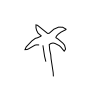

In [ ]:
# get a sample drawing from the test set, and render it to .svg
stroke_1 = test_set.random_sample()
draw_strokes(stroke_1)

In [ ]:
stroke_2 = test_set.random_sample()
draw_strokes(stroke_2)

In [ ]:
stroke_3 = test_set.random_sample()
draw_strokes(stroke_3)

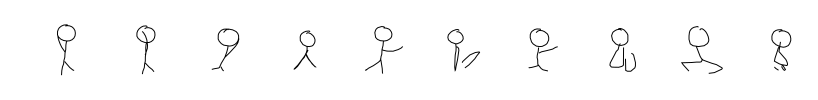

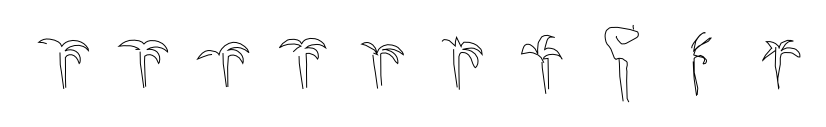

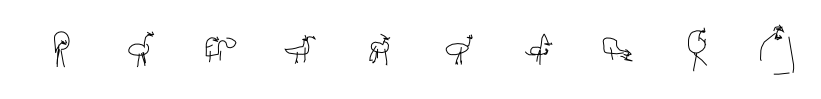

In [ ]:
# Create generated grid at various temperatures from 0.1 to 1.0
classes = [stroke_1, stroke_2, stroke_3]

for draw_class in classes:
  stroke_list = []
  for i in range(10):
    stroke_list.append([decode(draw_class, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
  stroke_grid = make_grid_svg(stroke_list)
  draw_strokes(stroke_grid)

In [ ]:
z_list = [] # interpolate spherically between z0 and z1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(stroke_1, stroke_2, t))

In [ ]:
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False), [0, i]])

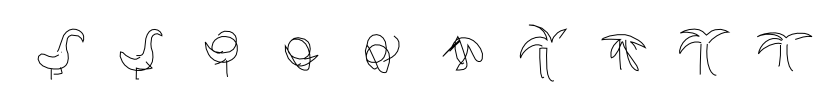

In [ ]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)